# Finding Sentiment of PubMed Article Abstracts 

This notebook extracts papers from PubMed and BioMed and put the results in a dataframe. Helpful functions for expracting papers from PubMed is taken from https://gist.github.com/bonzanini/5a4c39e4c02502a8451d 
Frequency distribution of articles are calculated using FreqDIST and CountVectorizer. Sentiment of article abstracts are determined using SentimentIntensityAnalyzer.

In [574]:
from Bio import Entrez
from Bio import Medline
import numpy as np
import json
import pandas as pd
import requests
from datetime import datetime, date, time
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pycountry
#from statistics import mode
import nltk
from nltk.corpus import stopwords


In [227]:
#nltk.download()

In [575]:
#Function to fetch papers using PubMed API
def esearch(query):
    Entrez.email = 'bkjboppana@gmail.com'
    search = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax='8000',
                            retmode='xml', 
                            term=query)
    papers = Entrez.read(search)
    return papers 

def efetch(idlist):
    ids = ','.join(idlist)
    Entrez.email = 'bkjboppana@gmail.com'
    fetch = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    papers = Entrez.read(fetch)
    return papers

In [651]:
#results = esearch('Parkinson AND treatment')  #searching ID using esearch from PubMed API
#id_list = results['IdList']     
papers = efetch(id_list)  #Fetching papers in XML format using efetch function


Creating a dictionary with country names and their abbrevation. This dictionary will be used to determine Affliation country of the author

In [ ]:
from collections import Counter
def findmode(countrylst):
    counter = Counter(countrylst)
    _,val = counter.most_common(1)[0]
    mode1= [x for x,y in counter.items() if y == val]
    return mode1[0]

In [ ]:
Countries_names = {}
for country in pycountry.countries:
    Countries_names[country.name] = [country.alpha_2,country.alpha_3]
USA_states = ["Alabama","AL","Alaska","AK","Arizona","AZ","Arkansas","AR","California","CA","Colorado","CO","Connecticut","CT",
"Delaware","DE","Florida","FL","Georgia","GA","Hawaii","HI","Idaho","ID","Illinois","IL","Indiana","IN","Iowa","IA",
"Kansas","KS","Kentuky","KY","Louisiana","LA","Maine","ME","Maryland","MD","Massachusetts","MA","Michigan","MI",
"Minnesota","MN","Mississipi","MS","Missouri","MO","Montana","MT","Nebraska","NE","Nevada","NV","Hampshire","NH",
"Jersey","NJ","NM", "New York","NY","Carolina","NC","Dakota","ND","Ohio","OH","Oklahoma",
"OK","Oregon","OR","Pennsylvania","PA","Rhode","RI","Tennessee","TN",
"Texas","TX","Utah","UT","Vermont","VT","Virginia","VA","Washington","WA","WV","Wisconsin","WI",
"Wyoming","WY", "York"]
    #Countries_names[country.name] = country.alpha_3
#Insert remaining countries and other ONE OFF cases into dictionary Countries_names    
Countries_names['United States']=Countries_names['United States'] + ['States'] + USA_states + ['USA']
Countries_names['United Kingdom']=Countries_names['United Kingdom'] + ['England', 'Ireland', 'Scotland','UK','Kingdom']
Countries_names['Hong Kong']=Countries_names['Hong Kong'] + ['Hong']
Countries_names['South Korea']=['Korea', 'KR', 'KOR']
Countries_names['North Korea'] = ['KP', 'PRK']
Countries_names['New Zealand'] = Countries_names['New Zealand']+['Zealand']
Countries_names['Canada'] = Countries_names['Canada'] + ['Ontario']
Countries_names['Russia'] =  ['RU', 'RUS']
Countries_names['Germany'] =  Countries_names['Germany'] + ['Berlin']
Countries_names['Taiwan'] = ['TW', 'TWN']
Countries_names['Iran'] = ['IR', 'IRN']
Countries_names['Spain'] = Countries_names['Spain'] +['Madrid']+['Barcelona']
Countries_names['Czechia'] = Countries_names['Czechia'] + ['Czech']
Countries_names['United Arab Emirates'] = Countries_names['United Arab Emirates'] + ['UAE']
Countries_names['South Africa'] = Countries_names['South Africa'] + ['Africa']

Countries_names.pop("Korea, Republic of")
Countries_names.pop("Korea, Democratic People's Republic of")
Countries_names.pop("Russian Federation")
Countries_names.pop("Taiwan, Province of China")
Countries_names.pop("Iran, Islamic Republic of")

In [582]:
#Returns country from affiliation
def affliation_country(affiliation):
    wordlist = re.compile('\w+').findall(affiliation)
    #print wordlist
    for key in Countries_names:
           if key in wordlist:
                return key
           else:
                for keys in Countries_names[key]: 
                    if keys in wordlist:return key

Each PubMed Artice in the JSON tree is processed to extract Article Date, Article Title, authors, afflication and abstract

In [583]:
#Creating empty lists to insert paper date,keywords, abstract and title
ArticleDate =[]
keys=[]
abstract=[]
title=[]
authors= []
#authoraffiliations = []
country=[]
affiliations =[]
affiliation_country=[]
year=[]
for i,paper in enumerate(papers['PubmedArticle']):

#Parsing Article date. If Article date is not present look for revised date    
    try:
        d = paper['MedlineCitation']['Article']['ArticleDate'][0]   
    except IndexError:        
        d = paper['MedlineCitation']['DateRevised']
    dt = date(int(d['Year']),int(d['Month']),int(d['Day']))
    year.append(d['Year'])
#Insert date into article date array    
    ArticleDate.append(dt.strftime("%m/%d/%y"))
    #keys.append(paper['MedlineCitation']["KeywordList"])
#Parsing article title    
    title.append(paper['MedlineCitation']['Article']['ArticleTitle'])
#Extrating Grantlist country to identify country where research is done   
    try:
         paper_country = paper['MedlineCitation']['Article']["GrantList"][0]["Country"]
    except (KeyError) :
         paper_country = 'Country Unknown'
    country.append(paper_country)
#Parsing abstract for each article. If abstract is not present inser empty string    
    try:
        paper_abstract = paper['MedlineCitation']['Article']['Abstract']['AbstractText']
        
        abs_array= []
        for strings in paper_abstract:abs_array.append(strings.split('attributes=')[0])
        abs_array=' '.join(abs_array)
    except KeyError:
        abs_array = ""
    
    abstract.append(abs_array)    
    authorlist=[]
    affiliation=[]
    country_list=[]
    
#Parsing all author names and affiliations for the article and combing them with ,     
    try:
        for k,author in enumerate(paper['MedlineCitation']["Article"]["AuthorList"]):
            if 'CollectiveName' not in author:
               name = author["ForeName"]+ ' '+author["LastName"]
            authorlist.append(name)            
            try:
                for j,affil in enumerate(author["AffiliationInfo"]):    
                    affiliate = affil["Affiliation"]
                    country_affiliate = affliation_country(affiliate)
                    if country_affiliate == None:country_affiliate=paper_country
                    
                    #if country_affliliate = None
                    #print affiliate
                    country_list.append(country_affiliate)
                    affiliation.append(affiliate)
            except (IndexError,KeyError):
                affiliation=[]
    except (IndexError,KeyError):
            authorlist=[]
#Joining  author list and inserting them to authors list  
    authors.append(','.join(sorted(authorlist)))
    affiliations.append(','.join(sorted(affiliation)))
    if len(country_list)>1:
        affiliation_country.append(findmode(country_list))
        
     #print findmode(country_list) 
    elif len(country_list) == 1:
        
        affiliation_country.append(country_list[0])
    else:affiliation_country.append('Unknown Affiliation')
    
     #      print "error" 
      #     print i 
#json.dumps(papers['PubmedArticle'][1]['MedlineCitation'])
#json.dumps(papers['PubmedArticle'][1]['MedlineCitation']['Article']['ArticleTitle'])

In [584]:
#Inserting columns into Dataframe
pubmed_df = pd.DataFrame(columns = ['ArticleDate','Title'])
pubmed_df['ArticleDate'] = pd.Series(ArticleDate)
pubmed_df['Title'] = pd.Series(title)
pubmed_df['Abstract'] = pd.Series(abstract)
pubmed_df['Authors'] = pd.Series(authors)
pubmed_df['Affiliations'] = pd.Series(affiliations)
pubmed_df['Author_Country'] = pd.Series(affiliation_country)
pubmed_df['year'] = pd.Series(year)

In [585]:
pubmed_df.head(10)

,ArticleDate,Title,Abstract,Authors,Affiliations,Author_Country,year
0,06/16/14,Catecholamine autotoxicity. Implications for p...,Several neurodegenerative diseases involve los...,"David S Goldstein,Irwin J Kopin,Yehonatan Sharabi","Clinical Neurocardiology Section, Clinical Neu...",United States,2014
1,02/27/17,Land Plus Aquatic Therapy Versus Land-Based Re...,To assess whether a specific land-based physic...,"Daniele Volpe,Davide Ferrazzoli,Fabiola Bossio...","Department of Biomedical Engineering, Scientif...",Italy,2017
2,08/30/16,Current and experimental treatments of Parkins...,"Over a period of more than 50 years, the sympt...","Jörg B Schulz,Wolfgang Oertel","Department of Neurology, Hertie-Senior Researc...",Germany,2016
3,08/24/15,Repetitive Transcranial Magnetic Stimulation (...,Several studies have reported repetitive trans...,"Aparna Wagle Shukla,Carolynn Patten,David E Va...",Brain Rehabilitation Research Center of Excell...,United States,2015
4,06/23/18,Treatment of Visual Disorders in Parkinson Dis...,This article discusses visual disorders in bot...,"Joseph Savitt,Michaela Mathews","Department of Neurology, University of Marylan...",United States,2018
5,12/09/14,The medical treatment of Parkinson disease fro...,It took exactly 150 years since James Parkinso...,Stanley Fahn,Columbia University College of Physicians and ...,United States,2014
6,10/07/15,Deoxynyboquinones as NQO1-Activated Cancer The...,One of the major goals of cancer therapy is th...,"Elizabeth I Parkinson,Paul J Hergenrother","Department of Chemistry, Roger Adams Laborator...",United States,2015
7,02/27/17,Pain in Parkinson disease: a cross-sectional s...,"We aimed to evaluate prevalence, phenotype, an...","Carsten Buhmann,Katharina Wesemann,Nathalie Wr...","Department of Clinical Neuroscience, Karolinsk...",Germany,2017
8,11/05/16,Short-Term Adverse Outcomes After Deep Brain S...,Despite ongoing progress in our understanding ...,"Kejia Hu,Matthew M Hutter,Ziev B Moses,Ziv Wil...","Department of Neurosurgery, Massachusetts Gene...",United States,2016
9,11/11/16,Effects of coordination and manipulation thera...,To determine the effects of a new exercise tra...,"Caiyou Hu,Mingming Zhao,Mingsheng Zhang,Yu Che...","a Southern Medical University , Guangzhou , Ch...",China,2016


In [586]:
#Dropping any dupliacte articles
pubmed_df=pubmed_df.drop_duplicates()


In [587]:
#Finding out total paper per author or group of authors and visualizing the Article count
author_total = pubmed_df.groupby(['Authors'],as_index=False).size()
total_papers  = pd.Series(author_total.values)
author_names = pd.Series(author_total.index)
df_author_total = pd.DataFrame(author_names[1:])
df_author_total["Total Papers"] = total_papers[1:]

df_author_total = df_author_total.sort_values("Total Papers",ascending=False)
#df_author_total

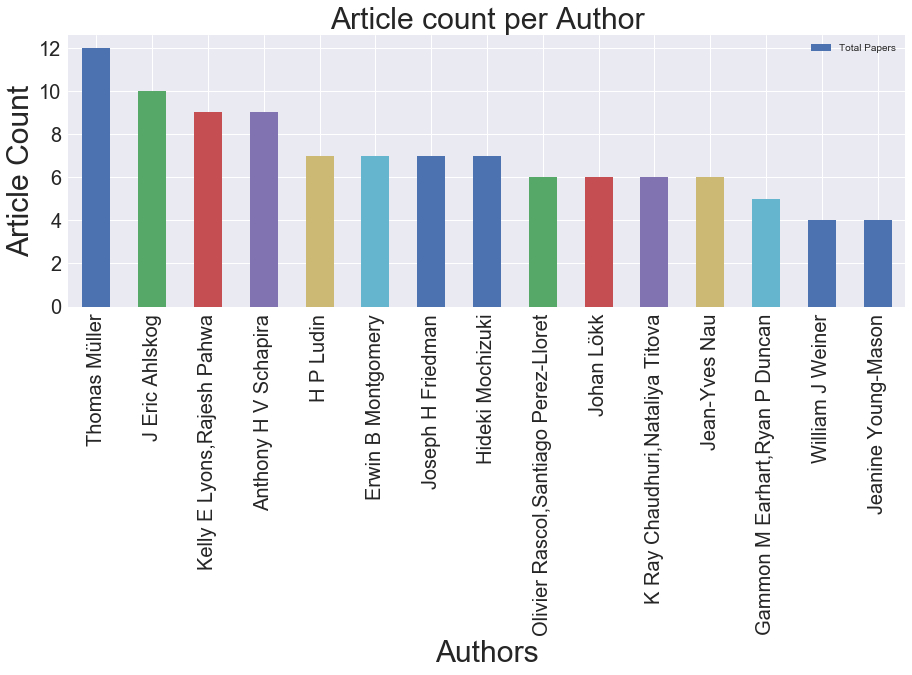

In [588]:
df_author_total.head(15).plot(x="Authors",y="Total Papers",kind='bar',figsize=(15,5),fontsize=20)
plt.title('Article count per Author',fontsize=30)
plt.xlabel('Authors',fontsize = 30) #xlabel
plt.ylabel('Article Count', fontsize = 30)#ylabel

In [589]:
#Finding out total paper per coutnry based on author's affliation country. If there are multiple countries, mode of countries is considered for that paper.
country_total = pubmed_df.groupby(['Author_Country'],as_index=False).size()
country_total_papers  = pd.Series(country_total.values)
country_names = pd.Series(country_total.index)
df_country_total = pd.DataFrame(country_names[1:])
df_country_total["TotalPapers_bycountry"] = country_total_papers[1:]
df_country_total = df_country_total.sort_values("TotalPapers_bycountry",ascending=False)

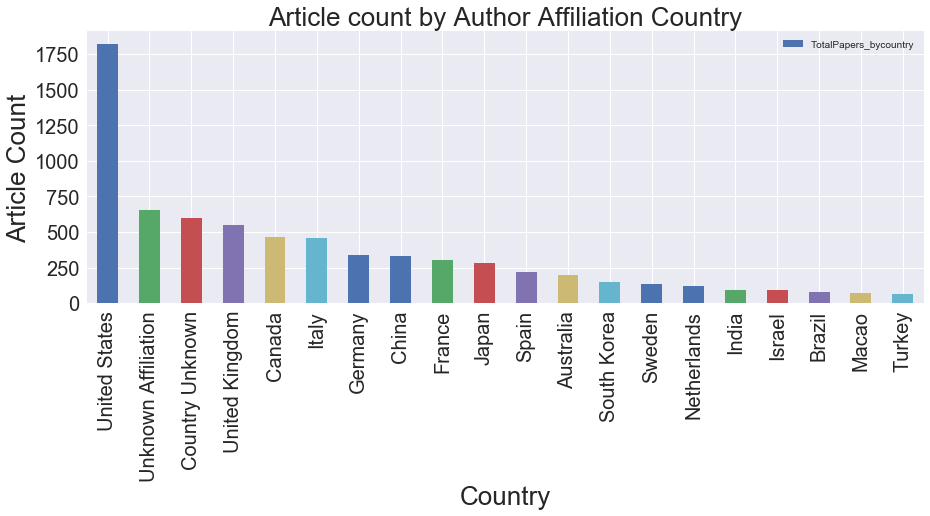

In [590]:
df_country_total.head(20).plot(x="Author_Country",y="TotalPapers_bycountry",kind='bar',figsize=(15,5),fontsize=20)
plt.title('Article count by Author Affiliation Country',fontsize=26)
plt.xlabel('Country',fontsize = 26) #xlabel
plt.ylabel('Article Count', fontsize = 26)#ylabel

In [479]:
pubmed_df.describe()

,ArticleDate,Title,Abstract,Authors,Affiliations,Author_Country,year
count,7996,7996,7996,7996,7996,7996,7996
unique,2654,7920,7123,7588,7222,113,18
top,11/21/13,Gene therapy for Parkinson's disease.,,,,United States,2016
freq,578,4,871,63,652,1819,1183


Implmenting NLP techniques to find out high frequency words and sentiment of the article 

In [591]:
nlp_df = pubmed_df
#nlp_df

In [592]:
nlp_df.head()

,ArticleDate,Title,Abstract,Authors,Affiliations,Author_Country,year
0,06/16/14,Catecholamine autotoxicity. Implications for p...,Several neurodegenerative diseases involve los...,"David S Goldstein,Irwin J Kopin,Yehonatan Sharabi","Clinical Neurocardiology Section, Clinical Neu...",United States,2014
1,02/27/17,Land Plus Aquatic Therapy Versus Land-Based Re...,To assess whether a specific land-based physic...,"Daniele Volpe,Davide Ferrazzoli,Fabiola Bossio...","Department of Biomedical Engineering, Scientif...",Italy,2017
2,08/30/16,Current and experimental treatments of Parkins...,"Over a period of more than 50 years, the sympt...","Jörg B Schulz,Wolfgang Oertel","Department of Neurology, Hertie-Senior Researc...",Germany,2016
3,08/24/15,Repetitive Transcranial Magnetic Stimulation (...,Several studies have reported repetitive trans...,"Aparna Wagle Shukla,Carolynn Patten,David E Va...",Brain Rehabilitation Research Center of Excell...,United States,2015
4,06/23/18,Treatment of Visual Disorders in Parkinson Dis...,This article discusses visual disorders in bot...,"Joseph Savitt,Michaela Mathews","Department of Neurology, University of Marylan...",United States,2018


In [596]:
#Creating a list of Abstracts and implementing steppng, deleting stopwords
import string
def text_process(abstract):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in abstract if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [597]:
abstract_processed = nlp_df['Abstract'].apply(text_process)
abstract_processed_list = abstract_processed.tolist()
#abstract_processed_list[:5]
new_list=[]
for lists in abstract_processed_list:
    new_list.extend(lists)
len(new_list)

962813

In [598]:
new_list2 = [a.encode('ascii', 'ignore') for a in new_list] #removing unicode from words

In [599]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
new_list1 = [lemmatizer.lemmatize(word) for word in new_list2]

In [600]:
new_list4 = [a.encode('ascii', 'ignore') for a in new_list1] #unicode is present after stepping. Removing unicode from words

In [601]:
#Computing frequency distribution of words using nltk.FreqDist and capturing top 200 common words
all_words = nltk.FreqDist(new_list4)
common_words = all_words.most_common(200)

In [602]:
#Removing dictionary words from most common words in abstract
from nltk.corpus import words
from nltk.corpus import brown
wordlist = set(brown.words())
wordlist_lowercased = set(i.lower() for i in brown.words())
mostcommon_words=[]
for i in common_words:
    if i not in wordlist_lowercased:mostcommon_words.append(i)

In [603]:
#Creating a dataframe with most common words from FreqDist
freq_df = pd.DataFrame(list(mostcommon_words), columns=['Word','Count'])
freq_df.head(25)

,Word,Count
0,patient,16862
1,pd,16571
2,disease,13713
3,parkinson,10282
4,treatment,9638
5,study,7170
6,motor,5514
7,effect,5130
8,therapy,4897
9,group,4861


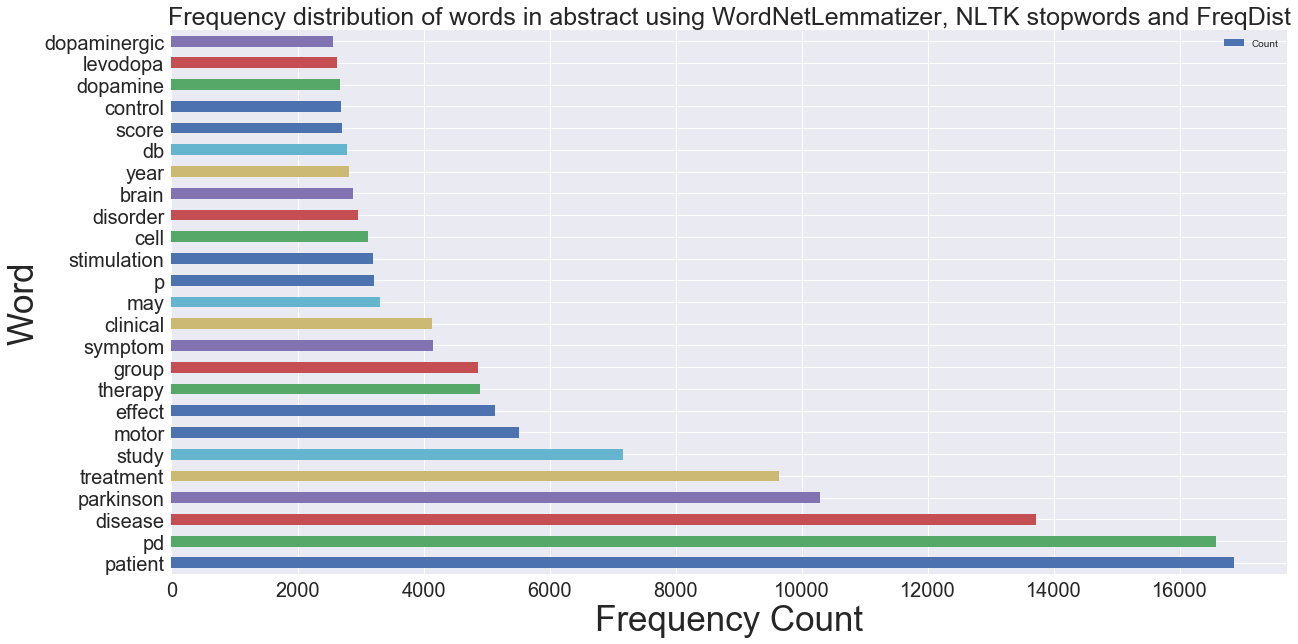

In [605]:
#Plotting the frequency count of words
freq_df.sort_values(by='Count', ascending=False).head(25).plot(x='Word',y='Count',kind='barh',figsize=(20,10),fontsize=20)
plt.title('Frequency distribution of words in abstract using WordNetLemmatizer, NLTK stopwords and FreqDist',fontsize=25)
plt.xlabel('Frequency Count',fontsize = 35) #xlabel
plt.ylabel('Word', fontsize = 35)#ylabel

In [606]:
#Implmenting Snowball Stemmer and count vectorizer to find out frequency of the words. TFidfTransformer implementation

In [607]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
nlp_df['stemmed'] =nlp_df.Abstract.map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
nlp_df.stemmed.head(10)

0    sever neurodegen diseas involv loss of catecho...
1    to assess whether a specif land-bas physic int...
2    over a period of more than 50 years, the sympt...
3    sever studi have report repetit transcrani mag...
4    this articl discuss visual disord in both park...
5    it took exact 150 year sinc jame parkinson des...
6    one of the major goal of cancer therapi is the...
7    we aim to evalu prevalence, phenotype, and the...
8    despit ongo progress in our understand of long...
9    to determin the effect of a new exercis train ...
Name: stemmed, dtype: object

In [618]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,2))
countvec
countvec.fit(nlp_df.stemmed)
len(countvec.vocabulary_)

492219

In [619]:
countvec_count = countvec.transform(nlp_df.stemmed)

In [624]:
occurrence = np.asarray(countvec_count.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': countvec.get_feature_names(), 'occurrences': occurrence})
df_occurrence=counts_df.sort_values(by='occurrences', ascending=False).head(20)
df_occurrence.dtypes

occurrences     int64
term           object
dtype: object

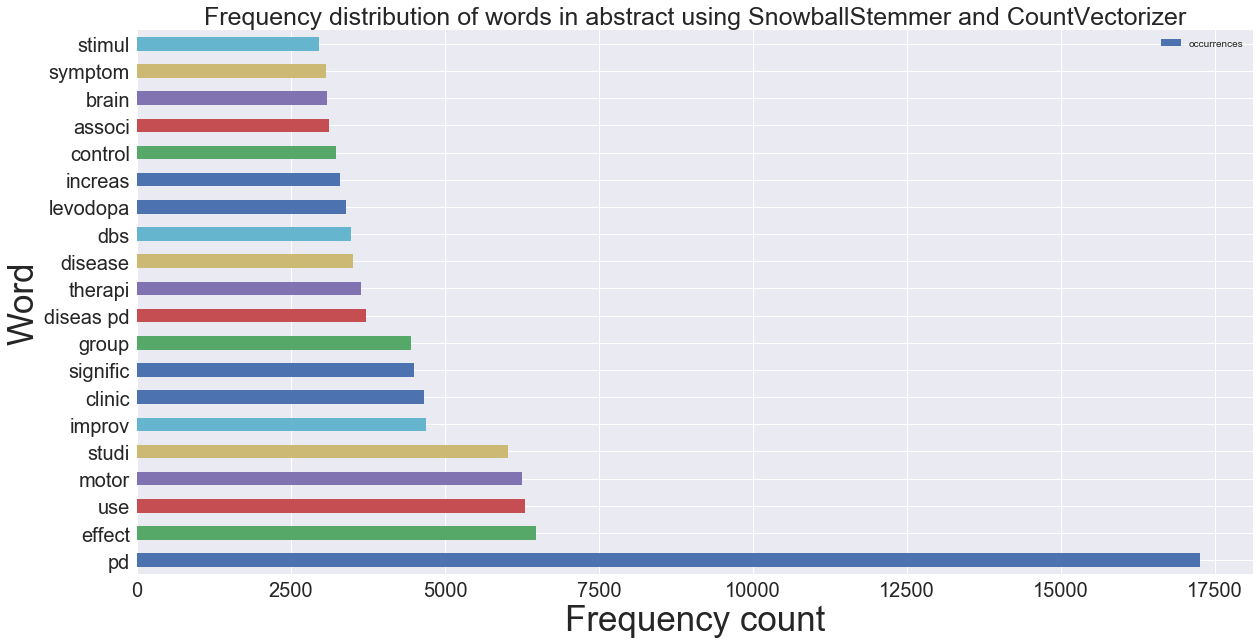

In [625]:
#Plotting number of occurences per word
df_occurrence.sort_values(by='occurrences', ascending=False).head(20).plot(x='term',y='occurrences',kind='barh',figsize=(20,10),fontsize=20)
plt.title('Frequency distribution of words in abstract using SnowballStemmer and CountVectorizer',fontsize=25)
plt.xlabel('Frequency count',fontsize = 35) #xlabel
plt.ylabel('Word', fontsize = 35)#ylabel

Implementing TfidfTransformer to determine the weight of words in the abstracts

In [628]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(countvec_count)
transformed_weights

<7996x492219 sparse matrix of type '<type 'numpy.float64'>'
	with 1461346 stored elements in Compressed Sparse Row format>

In [629]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': countvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
327984,pd,0.028391
287860,motor,0.013216
159874,effect,0.011500
122108,dbs,0.011379
473587,use,0.010803
428361,studi,0.010066
204516,group,0.009906
224735,improv,0.009746
92472,clinic,0.009705
255519,levodopa,0.009578


In [630]:
#Finding out weights using Tfidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english', ngram_range=(1,1))
tvec_weights = tvec.fit_transform(nlp_df.stemmed.dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
879,dbs,0.024108
2987,stn,0.016120
1037,dopa,0.013418
683,cognit,0.012001
1389,gait,0.011750
939,depress,0.010370
1403,gene,0.010298
1072,dyskinesia,0.010025
1956,mg,0.009913
581,case,0.009609


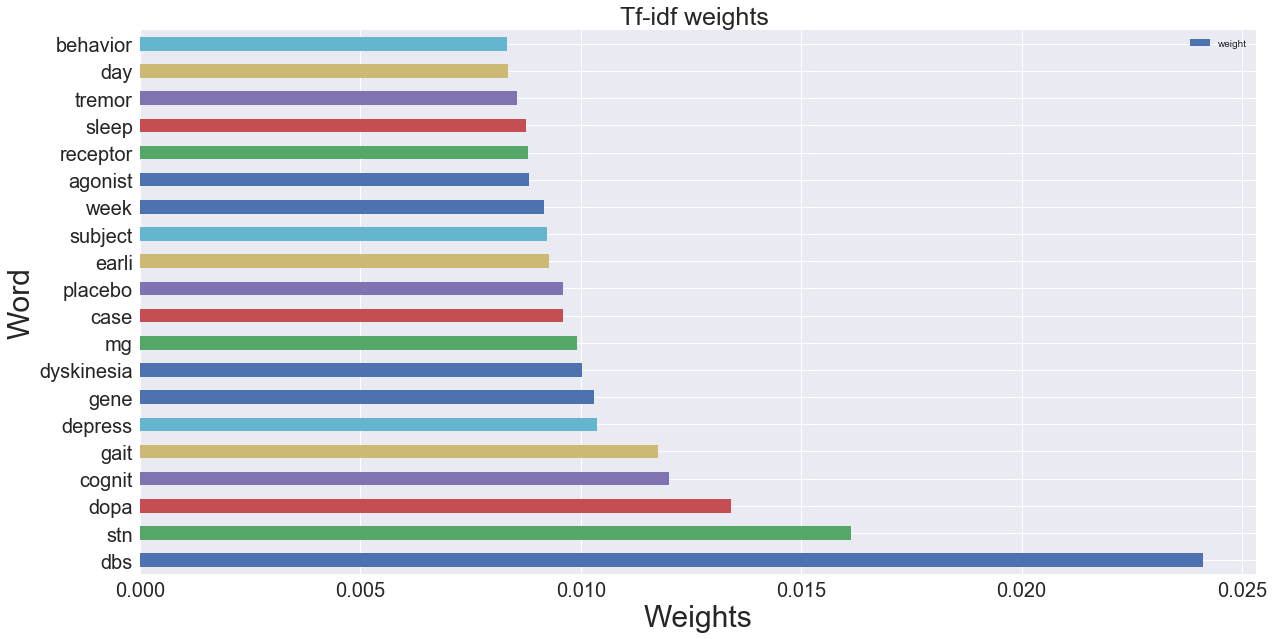

In [632]:
#Plotting weights computed using Tfidf Vectorizer
#weights_df.sort_values(by='weight', ascending=False).head(20).plot(x='term',y='weight',kind='barh',figsize=(15,5))
weights_df.sort_values(by='weight', ascending=False).head(20).plot(x='term',y='weight',kind='barh',figsize=(20,10),fontsize=20)
plt.title('Tf-idf weights ',fontsize=25)
plt.xlabel('Weights',fontsize = 30) #xlabel
plt.ylabel('Word', fontsize = 30)#ylabel

In [634]:
#Sentiment Analysis of abstracts using  SentimentIntensityAnalyzer

In [635]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

In [636]:
nlp_df.head()

,ArticleDate,Title,Abstract,Authors,Affiliations,Author_Country,year,stemmed
0,06/16/14,Catecholamine autotoxicity. Implications for p...,Several neurodegenerative diseases involve los...,"David S Goldstein,Irwin J Kopin,Yehonatan Sharabi","Clinical Neurocardiology Section, Clinical Neu...",United States,2014,sever neurodegen diseas involv loss of catecho...
1,02/27/17,Land Plus Aquatic Therapy Versus Land-Based Re...,To assess whether a specific land-based physic...,"Daniele Volpe,Davide Ferrazzoli,Fabiola Bossio...","Department of Biomedical Engineering, Scientif...",Italy,2017,to assess whether a specif land-bas physic int...
2,08/30/16,Current and experimental treatments of Parkins...,"Over a period of more than 50 years, the sympt...","Jörg B Schulz,Wolfgang Oertel","Department of Neurology, Hertie-Senior Researc...",Germany,2016,"over a period of more than 50 years, the sympt..."
3,08/24/15,Repetitive Transcranial Magnetic Stimulation (...,Several studies have reported repetitive trans...,"Aparna Wagle Shukla,Carolynn Patten,David E Va...",Brain Rehabilitation Research Center of Excell...,United States,2015,sever studi have report repetit transcrani mag...
4,06/23/18,Treatment of Visual Disorders in Parkinson Dis...,This article discusses visual disorders in bot...,"Joseph Savitt,Michaela Mathews","Department of Neurology, University of Marylan...",United States,2018,this articl discuss visual disord in both park...


In [637]:
#Sentiment of abstract is computed using compund score
sia = SentimentIntensityAnalyzer()
def tokenizing(sentence):
 tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
 token_sentence=tokenizer.tokenize(sentence)
 sentiment_score = sia.polarity_scores(sentence)
 #for key in scores:
 #max_value = [(value, key) for key, value in scores.items()[:-1]]
 if sentiment_score["compound"] == 0.0:
        sentiment='neutral'
 elif sentiment_score["compound"] > 0.0:
        sentiment='positive'
 else:
        sentiment = 'negative'
 return sentiment    

def scoring(sentence):
 
    sentiment_score = sia.polarity_scores(sentence)
    return sentiment_score
    

In [638]:
nlp_df['sentiment']= nlp_df['Abstract'].apply(tokenizing)

In [639]:
nlp_df['scores']= nlp_df['Abstract'].apply(scoring)

In [640]:
nlp_df.head()

,ArticleDate,Title,Abstract,Authors,Affiliations,Author_Country,year,stemmed,sentiment,scores
0,06/16/14,Catecholamine autotoxicity. Implications for p...,Several neurodegenerative diseases involve los...,"David S Goldstein,Irwin J Kopin,Yehonatan Sharabi","Clinical Neurocardiology Section, Clinical Neu...",United States,2014,sever neurodegen diseas involv loss of catecho...,negative,"{u'neg': 0.087, u'neu': 0.882, u'pos': 0.032, ..."
1,02/27/17,Land Plus Aquatic Therapy Versus Land-Based Re...,To assess whether a specific land-based physic...,"Daniele Volpe,Davide Ferrazzoli,Fabiola Bossio...","Department of Biomedical Engineering, Scientif...",Italy,2017,to assess whether a specif land-bas physic int...,negative,"{u'neg': 0.062, u'neu': 0.904, u'pos': 0.034, ..."
2,08/30/16,Current and experimental treatments of Parkins...,"Over a period of more than 50 years, the sympt...","Jörg B Schulz,Wolfgang Oertel","Department of Neurology, Hertie-Senior Researc...",Germany,2016,"over a period of more than 50 years, the sympt...",positive,"{u'neg': 0.054, u'neu': 0.888, u'pos': 0.058, ..."
3,08/24/15,Repetitive Transcranial Magnetic Stimulation (...,Several studies have reported repetitive trans...,"Aparna Wagle Shukla,Carolynn Patten,David E Va...",Brain Rehabilitation Research Center of Excell...,United States,2015,sever studi have report repetit transcrani mag...,positive,"{u'neg': 0.016, u'neu': 0.856, u'pos': 0.128, ..."
4,06/23/18,Treatment of Visual Disorders in Parkinson Dis...,This article discusses visual disorders in bot...,"Joseph Savitt,Michaela Mathews","Department of Neurology, University of Marylan...",United States,2018,this articl discuss visual disord in both park...,positive,"{u'neg': 0.07, u'neu': 0.757, u'pos': 0.173, u..."


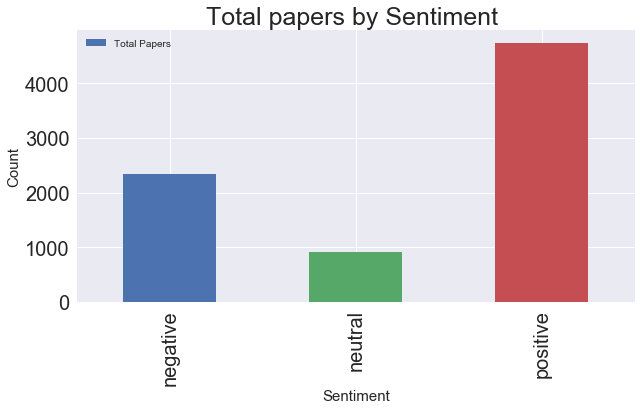

In [641]:
sentiment_total = nlp_df.groupby(['sentiment'],as_index=False).size()
total_papers  = pd.Series(sentiment_total.values)
sentiment= pd.Series(sentiment_total.index)
df_sentiment_total = pd.DataFrame(sentiment)
df_sentiment_total["Total Papers"] = total_papers
df_sentiment_total.plot(x="sentiment",y="Total Papers",kind='bar',figsize=(10,5),fontsize=20)
plt.title('Total papers by Sentiment ',fontsize=25)
plt.xlabel('Sentiment',fontsize = 15) #xlabel
plt.ylabel('Count', fontsize = 15)#ylabel

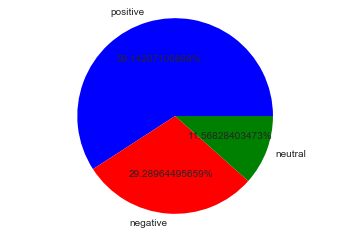

In [642]:
fig, ax = plt.subplots(1, 1)
ax.pie(nlp_df_sentimentscore.sentiment.value_counts(),autopct='%1.11f%%', labels=['positive','negative','neutral'], colors=['b','r','g'],radius=100)
plt.axis('equal')
#plt.ylabel('')
#plt.figsize(10,5)
plt.show()


In [643]:
nlp_df_sentimentscore = pd.concat([nlp_df.drop(['scores'], axis=1), nlp_df['scores'].apply(pd.Series)], axis=1)

In [644]:
nlp_df_sentimentscore.head()

,ArticleDate,Title,Abstract,Authors,Affiliations,Author_Country,year,stemmed,sentiment,compound,neg,neu,pos
0,06/16/14,Catecholamine autotoxicity. Implications for p...,Several neurodegenerative diseases involve los...,"David S Goldstein,Irwin J Kopin,Yehonatan Sharabi","Clinical Neurocardiology Section, Clinical Neu...",United States,2014,sever neurodegen diseas involv loss of catecho...,negative,-0.9201,0.087,0.882,0.032
1,02/27/17,Land Plus Aquatic Therapy Versus Land-Based Re...,To assess whether a specific land-based physic...,"Daniele Volpe,Davide Ferrazzoli,Fabiola Bossio...","Department of Biomedical Engineering, Scientif...",Italy,2017,to assess whether a specif land-bas physic int...,negative,-0.7272,0.062,0.904,0.034
2,08/30/16,Current and experimental treatments of Parkins...,"Over a period of more than 50 years, the sympt...","Jörg B Schulz,Wolfgang Oertel","Department of Neurology, Hertie-Senior Researc...",Germany,2016,"over a period of more than 50 years, the sympt...",positive,0.2500,0.054,0.888,0.058
3,08/24/15,Repetitive Transcranial Magnetic Stimulation (...,Several studies have reported repetitive trans...,"Aparna Wagle Shukla,Carolynn Patten,David E Va...",Brain Rehabilitation Research Center of Excell...,United States,2015,sever studi have report repetit transcrani mag...,positive,0.9891,0.016,0.856,0.128
4,06/23/18,Treatment of Visual Disorders in Parkinson Dis...,This article discusses visual disorders in bot...,"Joseph Savitt,Michaela Mathews","Department of Neurology, University of Marylan...",United States,2018,this articl discuss visual disord in both park...,positive,0.9623,0.070,0.757,0.173


In [645]:
#Wordcloud for positive and negative abstracts
from wordcloud import WordCloud,STOPWORDS

In [646]:
#Dataframe with positive sentiment
train_pos = nlp_df_sentimentscore[(nlp_df_sentimentscore['sentiment'] == 'positive') &(nlp_df_sentimentscore['pos'] > nlp_df_sentimentscore['neg']) ]
train_pos =nlp_df_sentimentscore['Abstract']
#Dataframe with negative sentiment
train_neg = nlp_df_sentimentscore[ (nlp_df_sentimentscore['sentiment'] == 'negative')& (nlp_df_sentimentscore['pos'] < nlp_df_sentimentscore['neg'])]
train_neg = nlp_df_sentimentscore['Abstract']

In [647]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")

#print("Negative words")
#wordcloud_draw(train_neg)

Positive words


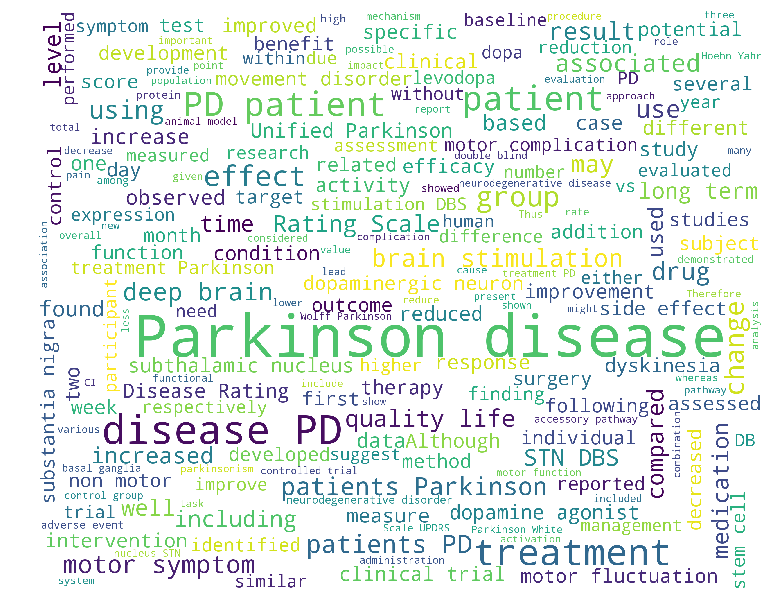

In [648]:
wordcloud_draw(train_pos,'white')

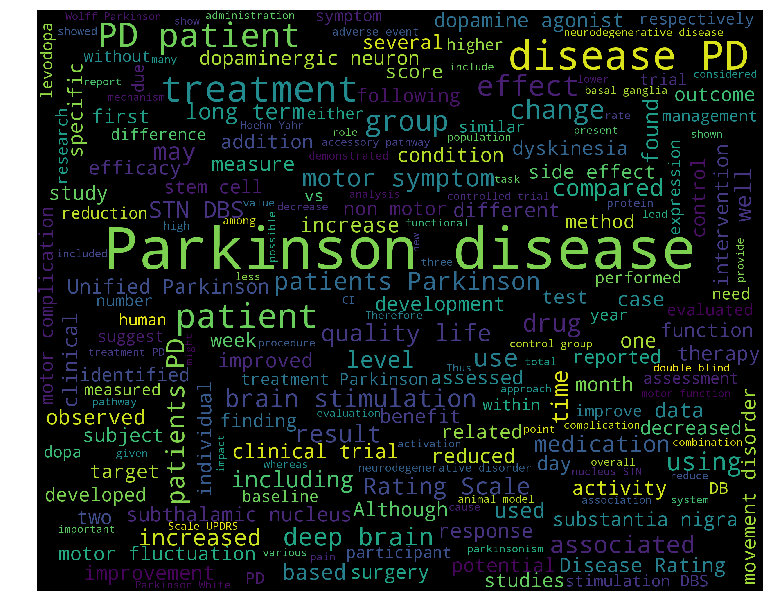

In [454]:
wordcloud_draw(train_neg,'black')

In [649]:
#Determining total number of papers published each year by sentiment
year_sentiment_group=nlp_df_sentimentscore.groupby(['year','sentiment']).size()

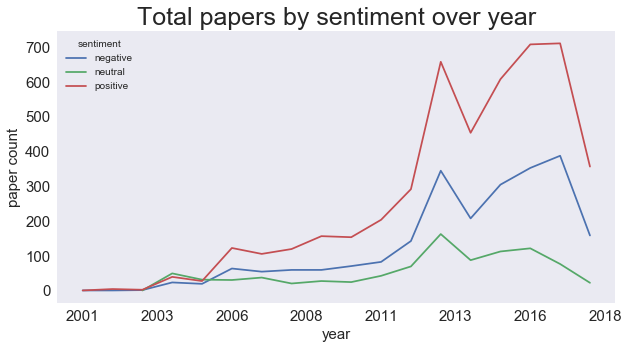

In [650]:
df_year=year_sentiment_group.unstack()
df_year.fillna(0)
df_year.plot(figsize=(10,5),fontsize=15)
plt.title('Total papers by sentiment over year',fontsize = 25)
plt.xlabel('year',fontsize = 15) #xlabel
plt.ylabel('paper count', fontsize = 15)#ylabel
plt.grid(b=None)